<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        if np.sum(S_mis * S_mis) == 0:
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape
    n_a_dts = S_dict['n_a_dts']
    n_a_mis = S_dict['n_a_mis']
    a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
    a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
    a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']
    a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']

    if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
      print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
    alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
    alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
    #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
    #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
    print("dts deltas ", alphas_dts)
    print("mis deltas ", alphas_mis)
    #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
    hyper_p_ret_ = []
    coefs_ = []
    for a_mis_value in tqdm.tqdm(alphas_mis):
      for a_dts_value in tqdm.tqdm(alphas_dts):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          #for a in tqdm.tqdm(alphas):
            #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
            dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X, y, dict_hyper_p_values)
            #print("alpha  ", a, "coef: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_dts_value, a_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
    estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
    hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf

'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [3]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [4]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data)#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][0]
    p_missing = dictio_data['p_missing'][0]
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [8]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = np.diag(s_within)
        print("final S in cov strategy std_mi ", S)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure']:
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo']  #, 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi_pure':
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      for i in range(dict_imp['mi_nbr']):
        print("i .-------------> ", i)
        dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        S = S_within[None, :, :] + S_between
        S = np.concatenate(S, axis=0)
        #print(S)
        alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
        best_coeff_partial, best_alpha_partial = coeff_results[:, idx_best], alphas_used[idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
        best_coeff /= dict_imp['mi_nbr']
      best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#      print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_alpha_delta_dts)



In [6]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        #mask_partial = dict_obser_partial['X_train_masked'][1]
        p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
        n_train = full_masks.shape[0]
        mask_partial = full_masks.copy()
        mask_partial[0:int(n_train * p_i), :] = 0
        #mask_partial = mask_no_both_seen[0:int(n_train * p_i), :]
        tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
        dict_obser['X_train_masked'] = tuple_partial
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'])
  ax_res[1].set_title(extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




change nbr_experiments to match the size of n_train
data :  [{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}, {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}]
n_tot :  [20010, 20010, 20010]
n_train :  [10, 10, 10]
n_test :  [20000, 20000, 20000]
dim :  [2, 2, 2]
beta_gt :  [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])]
perc_test :  [0.9995002498750625, 0.9995002498750625, 0.9995002498750625]
err :  [{'type': 'Gaussian_on_y', 'scaling': 1.5}, {'type': 'Gaussian_on_y', 'scaling': 1.5}, {'type': 'Gaussian_on_y', 'scaling': 1.5}]
plots :  [[], [], []]
p_miss :  [[1, 0.0, 0.0], [0.9, 0.04999999999999999, 0.04999999999999999], [0.8, 0.09999999999999998, 0.09999999999999998]]
generation :  fixed
title_infer_error :    inference_error
title_test_error :    test_error
info_algo :  {'adv_rad_times_delta_dts_ma

100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.4986480498165298
---------------------------------> best coeff  [-0.85141387  1.82346755]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01908641 0.97631763]
crush test------------------------------------------------->  3.2045967629412284
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.01908641 0.        ]
 [0.         0.97631763]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm

100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.4986480498165315
---------------------------------> best coeff  [-0.85141387  1.82346755]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01908641 0.97631763]
crush test------------------------------------------------->  16.02298381470615
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[1.01908641 0.        ]
 [0.         0.97631763]]
S missing shape
  (10, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]

100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.4986480498165293
---------------------------------> best coeff  [-0.85141387  1.82346755]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01908641 0.97631763]
crush test------------------------------------------------->  16.02298381470615
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[1.01908641 0.        ]
 [0.         0.97631763]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.498648051666952
---------------------------------> best coeff  [-0.85141388  1.82346755]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.46586763, -0.03565798],
       [-0.37682338, -0.26747261],
       [ 0.50286897, -1.06983888],
       [ 1.9915466 ,  0.38833027],
       [ 1.25036382, -0.76102935],
  

100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.278015646010226
---------------------------------> best coeff  [-0.4913054   1.91523151]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01908641 0.97631763]
crush test------------------------------------------------->  3.2045967629412284
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.01908641 0.        ]
 [0.         0.97631763]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mis

dts deltas  [1.00000000e-04 1.62377674e-04 2.63665090e-04 4.28133240e-04
 6.95192796e-04 1.12883789e-03 1.83298071e-03 2.97635144e-03
 4.83293024e-03 7.84759970e-03 1.27427499e-02 2.06913808e-02
 3.35981829e-02 5.45559478e-02 8.85866790e-02 1.43844989e-01
 2.33572147e-01 3.79269019e-01 6.15848211e-01 1.00000000e+00]
mis deltas  [0.]


100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.4986480498165315
---------------------------------> best coeff  [-0.85141387  1.82346755]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01908641 0.97631763]
crush test------------------------------------------------->  25.50842550355369
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[1.01908641 0.        ]
 [0.         0.73108072]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[

100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.2737155010732613
---------------------------------> best coeff  [-0.5065698  1.9618871]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01908641 0.97631763]
crush test------------------------------------------------->  25.50842550355369
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[1.01908641 0.        ]
 [0.         0.73108072]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.

100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  2.274345344079591
---------------------------------> best coeff  [-0.55794139  2.03868581]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.46586763, -0.03565798],
       [-0.37682338, -0.26747261],
       [ 0.50286897, -1.06983888],
       [ 1.9915466 ,  0.38833027],
       [ 1.25036382, -0.76102935],
  

100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.2889011640054377
---------------------------------> best coeff  [-0.49752361  1.86563324]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01908641 0.97631763]
crush test------------------------------------------------->  3.2045967629412284
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.01908641 0.        ]
 [0.         0.97631763]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mi

100%|██████████| 1/1 [00:00<00:00, 12.62it/s]

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.4986480498165315
---------------------------------> best coeff  [-0.85141387  1.82346755]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01908641 0.97631763]


crush test------------------------------------------------->  24.926914744682506
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[1.01908641 0.        ]
 [0.         0.77190159]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.78137936]]

 [[0.         0.        ]
  [0.         0.77388793]]]
shape X_imputed in post_imputation  (5, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  8  nbr_miss :  2
X  10   2
y shape (10,)
nm  20
S_mis in Adbvt training  [[[0.         0.        ]
  [0.         0.       

100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.276188792545079
---------------------------------> best coeff  [-0.55965613  1.99004719]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01908641 0.97631763]
crush test------------------------------------------------->  24.926914744682506
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[1.01908641 0.        ]
 [0.         0.77190159]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.       

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4527751929788337
---------------------------------> best coeff  [-0.46607729  1.55206688]
mi
conc
cond_var
std_nan
5
x_axis for print in plot_res---->  [1, 0.9, 0.8]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.85141387,  1.82346755]), array([-0.4913054 ,  1.91523151]), array([-0.49752361,  1.86563324])], 'l2_dist_best_coeff_gt': [np.float64(0.39326252757142316), np.float64(0.08521321805240141), np.float64(0.1343895764172059)], 'best_score': [np.float64(2.4986480498165298), np.float64(2.278015646010226), np.float64(2.2889011640054377)], 'best_alpha': [np.float64(1.0526315789473686), np.float64(4.0), np.float64(4.0)]}
key  ('oracle', 'sd') :  {'best_coeff': [array([-0.85141387,  1.82346755]), array([-0.85141387,  1.82346755]), array([-0.85141387,  1.82346755])], 'l2_dist_best_coeff_gt': [n

100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.298743873462986
---------------------------------> best coeff  [-0.38569543  1.9845505 ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5431111  0.48514391]
crush test------------------------------------------------->  -13.381351965872367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.5431111  0.        ]
 [0.         0.48514391]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mi

100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.298743873462986
---------------------------------> best coeff  [-0.38569543  1.9845505 ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5431111  0.48514391]
crush test------------------------------------------------->  -66.90675982936183
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[0.5431111  0.        ]
 [0.         0.48514391]]
S missing shape
  (10, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
shape X_

100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.2987438734629855
---------------------------------> best coeff  [-0.38569543  1.9845505 ]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5431111  0.48514391]
crush test------------------------------------------------->  -66.90675982936183
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[0.5431111  0.        ]
 [0.         0.48514391]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  

100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.2987438734653773
---------------------------------> best coeff  [-0.38569543  1.9845505 ]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-1.04461949, -0.33028925],
       [-0.49336387, -0.04738294],
       [-0.06340393, -0.87028703],
       [-0.40984646, -1.69054324],
       [ 0.20516971, -0.45191272],
       [-1

100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.2880850601986156
---------------------------------> best coeff  [-0.50682239  1.98458397]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5431111  0.48514391]
crush test------------------------------------------------->  -13.381351965872367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.5431111  0.        ]
 [0.         0.48514391]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
n

100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.298743873462986
---------------------------------> best coeff  [-0.38569543  1.9845505 ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5431111  0.48514391]
crush test------------------------------------------------->  -70.35257492136604
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[0.5431111 0.       ]
 [0.        0.4697261]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.

100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.288799809944604
---------------------------------> best coeff  [-0.53196903  1.99523109]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5431111  0.48514391]
crush test------------------------------------------------->  -70.35257492136604
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[0.5431111 0.       ]
 [0.        0.4697261]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.  

100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.2940453765985342
---------------------------------> best coeff  [-0.49747946  1.92461231]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-1.04461949, -0.33028925],
       [-0.49336387, -0.04738294],
       [-0.06340393, -0.87028703],
       [-0.40984646, -1.69054324],
       [ 0.20516971, -0.45191272],
 

100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.287672132112854
---------------------------------> best coeff  [-0.48930038  1.98879745]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5431111  0.48514391]
crush test------------------------------------------------->  -13.381351965872367
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.5431111  0.        ]
 [0.         0.48514391]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm

100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.298743873462986
---------------------------------> best coeff  [-0.38569543  1.9845505 ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5431111  0.48514391]
crush test------------------------------------------------->  -71.38740125370121
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[0.5431111  0.        ]
 [0.         0.49794608]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.       

100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.311226395700975
---------------------------------> best coeff  [-0.65767144  2.00815172]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.5431111  0.48514391]
crush test------------------------------------------------->  -71.38740125370121
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[0.5431111  0.        ]
 [0.         0.49794608]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         

100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  2.3165018039684697
---------------------------------> best coeff  [-0.61216911  1.92781063]
mi
conc
cond_var
std_nan
5


x_axis for print in plot_res---->  [1, 0.9, 0.8]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.38569543,  1.9845505 ]), array([-0.50682239,  1.98458397]), array([-0.48930038,  1.98879745])], 'l2_dist_best_coeff_gt': [np.float64(0.11534392823509786), np.float64(0.01685820451859503), np.float64(0.015491259712622042)], 'best_score': [np.float64(2.298743873462986), np.float64(2.2880850601986156), np.float64(2.287672132112854)], 'best_alpha': [np.float64(4.0), np.float64(1.0526315789473686), np.float64(1.0526315789473686)]}
key  ('oracle', 'sd') :  {'best_coeff': [array([-0.38569543,  1.9845505 ]), array([-0.38569543,  1.9845505 ]), array([-0.38569543,  1.9845505 ])], 'l2_dist_best_coeff_gt': [np.float64(0.11534392823509786), np.float64(0.11534392823509786), np.float64(0.11534392823509786)], 'best_score': [np.float64(2.298743873462986), np.float64(2.298743873462986), np.float64(2.298743873462986)], 'best_alpha': [np.float64(4.0), np.float64(4.0), np.float64(4.0)]}
key  ('mi', 'mean

100%|██████████| 1/1 [00:00<00:00, 15.61it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.7210275774587824
---------------------------------> best coeff  [-0.08053402  1.15259347]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07842874 0.79942591]
crush test------------------------------------------------->  3.656203036022863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.07842874 0.        ]
 [0.         0.79942591]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mis

100%|██████████| 1/1 [00:00<00:00, 12.53it/s]

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.7210275774587807
---------------------------------> best coeff  [-0.08053402  1.15259347]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07842874 0.79942591]


crush test------------------------------------------------->  18.28101518011432
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[1.07842874 0.        ]
 [0.         0.79942591]]
S missing shape
  (10, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
shape X_imputed in post_imputation  (5, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mis in Adbvt training  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
no missing part
one matrix in input, S.shape = (n, n)
dts deltas  [1.00000000e-04 1.62377674e-04 2.63665090e-04 4.28133240e-04
 6.95192796e-04 1.1288

100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.7210275774587824
---------------------------------> best coeff  [-0.08053402  1.15259347]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07842874 0.79942591]
crush test------------------------------------------------->  18.28101518011432
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[1.07842874 0.        ]
 [0.         0.79942591]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [

100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.721027579098767
---------------------------------> best coeff  [-0.08053402  1.15259347]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.4309068 ,  1.27717308],
       [ 0.78679612,  0.4209993 ],
       [-1.60405425, -0.71095215],
       [-0.47668582, -0.3439042 ],
       [ 2.58294987,  1.72347236],
       [-0.

100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.772279451919737
---------------------------------> best coeff  [-0.059492    1.10739362]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07842874 0.79942591]
crush test------------------------------------------------->  3.656203036022863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.07842874 0.        ]
 [0.         0.79942591]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mis 

100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.7210275774587807
---------------------------------> best coeff  [-0.08053402  1.15259347]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07842874 0.79942591]
crush test------------------------------------------------->  18.07570619434677
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[1.07842874 0.        ]
 [0.         0.83793118]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.       

100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.7244681560608077
---------------------------------> best coeff  [-0.07910068  1.14948554]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07842874 0.79942591]
crush test------------------------------------------------->  18.07570619434677
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[1.07842874 0.        ]
 [0.         0.83793118]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.       

100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.784263337128368
---------------------------------> best coeff  [-0.0544782   1.09711769]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.4309068 ,  1.27717308],
       [ 0.78679612,  0.4209993 ],
       [-1.60405425, -0.71095215],
       [-0.47668582, -0.3439042 ],
       [ 2.58294987,  1.72347236],
       [-0.

100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.7236829560343807
---------------------------------> best coeff  [-0.11471521  1.15604393]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07842874 0.79942591]
crush test------------------------------------------------->  3.656203036022863
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.07842874 0.        ]
 [0.         0.79942591]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mis

100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.7210275774587807
---------------------------------> best coeff  [-0.08053402  1.15259347]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07842874 0.79942591]
crush test------------------------------------------------->  22.32446677375817
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[1.10507185 0.        ]
 [0.         0.83793118]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.       

100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.7627029610328004
---------------------------------> best coeff  [-0.09316487  1.12052108]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.07842874 0.79942591]
crush test------------------------------------------------->  22.32446677375817
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[1.10507185 0.        ]
 [0.         0.83793118]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.       

100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.8919003756346275
---------------------------------> best coeff  [-0.02770397  1.01204822]
mi
conc
cond_var
std_nan
5
x_axis for print in plot_res---->  [1, 0.9, 0.8]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.08053402,  1.15259347]), array([-0.059492  ,  1.10739362]), array([-0.11471521,  1.15604393])], 'l2_dist_best_coeff_gt': [np.float64(0.945541926775188), np.float64(0.9953860779010106), np.float64(0.9277425382956681)], 'best_score': [np.float64(2.7210275774587824), np.float64(2.772279451919737), np.float64(2.7236829560343807)], 'best_alpha': [np.float64(4.0), np.float64(4.0), np.float64(4.0)]}
key  ('oracle', 'sd') :  {'best_coeff': [array([-0.08053402,  1.15259347]), array([-0.08053402,  1.15259347]), array([-0.08053402,  1.15259347])], 'l2_dist_best_coeff_gt': [np.float64(0.945541

100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  4.775963672728756
---------------------------------> best coeff  [7.40019442e-01 1.56365006e-11]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0859517  1.01048071]
crush test------------------------------------------------->  -10.753426096849385
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.0859517  0.        ]
 [0.         1.01048071]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (1

100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  4.775963672728756
---------------------------------> best coeff  [7.40019442e-01 1.56365006e-11]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0859517  1.01048071]
crush test------------------------------------------------->  -53.76713048424692
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[1.0859517  0.        ]
 [0.         1.01048071]]
S missing shape
  (10, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0.

100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  4.775963672728756
---------------------------------> best coeff  [7.40019442e-01 1.56365006e-11]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0859517  1.01048071]
crush test------------------------------------------------->  -53.76713048424692
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[1.0859517  0.        ]
 [0.         1.01048071]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  4.775963654077953
---------------------------------> best coeff  [7.40019160e-01 1.59733281e-10]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-1.29972371, -0.90987911],
       [ 0.7124994 , -0.28957198],
       [-0.36227172, -0.0462193 ],
       [-2.51714519, -1.43234689],
       [ 0.34008605,  1.2143952

100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  4.776109986837974
---------------------------------> best coeff  [7.42202058e-01 5.14834609e-11]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0859517  1.01048071]
crush test------------------------------------------------->  -10.753426096849385
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.0859517  0.        ]
 [0.         1.01048071]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (1

100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  4.775963672728756
---------------------------------> best coeff  [7.40019442e-01 1.56365006e-11]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0859517  1.01048071]
crush test------------------------------------------------->  -55.741826986391054
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[1.07202136 0.        ]
 [0.         1.01048071]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        

100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  4.776648761463115
---------------------------------> best coeff  [7.49266234e-01 3.12731018e-09]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0859517  1.01048071]
crush test------------------------------------------------->  -55.741826986391054
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[1.07202136 0.        ]
 [0.         1.01048071]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.  

100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  4.77610997116
---------------------------------> best coeff  [7.42202093e-01 7.35820193e-09]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-1.29972371, -0.90987911],
       [ 0.7124994 , -0.28957198],
       [-0.36227172, -0.0462193 ],
       [-2.51714519, -1.43234689],
       [ 0.34008605,  1.21439522],


100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  4.776109985814937
---------------------------------> best coeff  [7.42202067e-01 7.29674806e-10]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0859517  1.01048071]
crush test------------------------------------------------->  -10.753426096849385
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.0859517  0.        ]
 [0.         1.01048071]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (1

100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  4.775963672728756
---------------------------------> best coeff  [7.40019442e-01 1.56365006e-11]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0859517  1.01048071]
crush test------------------------------------------------->  -59.96444079704858
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[1.07202136 0.        ]
 [0.         0.89548326]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]

100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  4.590650090480955
---------------------------------> best coeff  [0.9964377 0.1315165]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0859517  1.01048071]
crush test------------------------------------------------->  -59.96444079704858
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[1.07202136 0.        ]
 [0.         0.89548326]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  4.016111398140795
---------------------------------> best coeff  [0.74724489 0.36104044]
mi
conc
cond_var
std_nan
5
x_axis for print in plot_res---->  [1, 0.9, 0.8]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([7.40019442e-01, 1.56365006e-11]), array([7.42202058e-01, 5.14834609e-11]), array([7.42202067e-01, 7.29674806e-10])], 'l2_dist_best_coeff_gt': [np.float64(2.353220817538026), np.float64(2.3543716683468885), np.float64(2.354371672759908)], 'best_score': [np.float64(4.775963672728756), np.float64(4.776109986837974), np.float64(4.776109985814937)], 'best_alpha': [np.float64(0.4210526315789478), np.float64(0.4210526315789478), np.float64(0.4210526315789478)]}
key  ('oracle', 'sd') :  {'best_coeff': [array([7.40019442e-01, 1.56365006e-11]), array([7.40019442e-01, 1.56365006e-11]), array([7.400

100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4615342898423114
---------------------------------> best coeff  [-0.34343674  1.48638364]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90179773 1.14538929]
crush test------------------------------------------------->  -9.193583642989456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.90179773 0.        ]
 [0.         1.14538929]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mi

100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4615342898423114
---------------------------------> best coeff  [-0.34343674  1.48638364]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90179773 1.14538929]
crush test------------------------------------------------->  -45.96791821494727
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[0.90179773 0.        ]
 [0.         1.14538929]]
S missing shape
  (10, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
shape X

100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.461534289842312
---------------------------------> best coeff  [-0.34343674  1.48638364]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90179773 1.14538929]
crush test------------------------------------------------->  -45.96791821494727
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[0.90179773 0.        ]
 [0.         1.14538929]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [

100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.461534290862351
---------------------------------> best coeff  [-0.34343674  1.48638364]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[ 0.61603545,  0.69910681],
       [-1.045323  , -1.90749864],
       [-0.49641359, -0.31317292],
       [-0.04307104,  0.65839934],
       [ 0.87986173, -1.01862862],
       [-1.

100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.466107989913252
---------------------------------> best coeff  [-0.54630593  1.59102656]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90179773 1.14538929]
crush test------------------------------------------------->  -9.193583642989456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.90179773 0.        ]
 [0.         1.14538929]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mis

100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4615342898423114
---------------------------------> best coeff  [-0.34343674  1.48638364]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90179773 1.14538929]
crush test------------------------------------------------->  -51.15601956678059
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[0.90179773 0.        ]
 [0.         1.19884619]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.      

100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  2.4895770381247684
---------------------------------> best coeff  [-0.51456353  1.54496359]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90179773 1.14538929]
crush test------------------------------------------------->  -51.15601956678059
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[0.90179773 0.        ]
 [0.         1.19884619]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.        

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0078476 0.       ] , min score  2.511857234615764
---------------------------------> best coeff  [-0.49780291  1.51183893]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}


(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[ 0.61603545,  0.69910681],
       [-1.045323  , -1.90749864],
       [-0.49641359, -0.31317292],
       [-0.04307104,  0.65839934],
       [ 0.87986173, -1.01862862],
       [-1.17713195, -1.75811516],
       [ 0.37471436, -0.39850292],
       [-0.23586603,  1.3800707 ],
       [-2.24929827, -2.15946133],
       [-0.91622648, -0.08306208]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.]])), 'X_test': array([[ 2.1599375 , -0.24298497],
       [ 0.50942665,  0.36210243],
       [-0.4851849 , -0.70906283],
       ...,
       [ 0.17108831,  0.36828807],
       [ 2.42599748,  2.74699752]

100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.5755408434618823
---------------------------------> best coeff  [-0.32001229  1.36105311]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90179773 1.14538929]
crush test------------------------------------------------->  -9.193583642989456
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.90179773 0.        ]
 [0.         1.14538929]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm

100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4615342898423114
---------------------------------> best coeff  [-0.34343674  1.48638364]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90179773 1.14538929]
crush test------------------------------------------------->  -36.806757069389434
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[0.70331282 0.        ]
 [0.         1.19884619]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.     

100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.612545539113217
---------------------------------> best coeff  [-0.21204579  1.2901704 ]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.90179773 1.14538929]
crush test------------------------------------------------->  -36.806757069389434
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[0.70331282 0.        ]
 [0.         1.19884619]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.        

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  2.7631635061484885
---------------------------------> best coeff  [-0.29813078  1.20029224]
mi
conc
cond_var
std_nan
5
x_axis for print in plot_res---->  [1, 0.9, 0.8]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.34343674,  1.48638364]), array([-0.54630593,  1.59102656]), array([-0.32001229,  1.36105311])], 'l2_dist_best_coeff_gt': [np.float64(0.5369486207391794), np.float64(0.41158658385704133), np.float64(0.6638137554275304)], 'best_score': [np.float64(2.4615342898423114), np.float64(2.466107989913252), np.float64(2.5755408434618823)], 'best_alpha': [np.float64(4.0), np.float64(4.0), np.float64(0.8421052631578947)]}
key  ('oracle', 'sd') :  {'best_coeff': [array([-0.34343674,  1.48638364]), array([-0.34343674,  1.48638364]), array([-0.34343674,  1.48638364])], 'l2_dist_best_coeff

100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  2.3117078249570024
---------------------------------> best coeff  [-0.29774651  2.0005689 ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.25408627 1.13423724]
crush test------------------------------------------------->  2.861924861839242
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.25408627 0.        ]
 [0.         1.13423724]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm 

100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  2.3117078249570024
---------------------------------> best coeff  [-0.29774651  2.0005689 ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.25408627 1.13423724]
crush test------------------------------------------------->  14.309624309196213
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[1.25408627 0.        ]
 [0.         1.13423724]]
S missing shape
  (10, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  2.311707824957003
---------------------------------> best coeff  [-0.29774651  2.0005689 ]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.25408627 1.13423724]
crush test------------------------------------------------->  14.309624309196213
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[1.25408627 0.        ]
 [0.         1.13423724]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0

100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  2.3117078249862284
---------------------------------> best coeff  [-0.29774651  2.0005689 ]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[ 2.65298775,  0.51808131],
       [-0.160418  , -0.12853153],
       [ 1.74563685, -0.08094704],
       [-1.06895887, -2.05271653],
       [ 1.10710016,  1.04496575],
 

100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00183298 0.        ] , min score  2.319012499456475
---------------------------------> best coeff  [-0.27576775  1.99205613]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.25408627 1.13423724]
crush test------------------------------------------------->  2.861924861839242
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.25408627 0.        ]
 [0.         1.13423724]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  2

100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  2.3117078249570024
---------------------------------> best coeff  [-0.29774651  2.0005689 ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.25408627 1.13423724]
crush test------------------------------------------------->  16.900986520302272
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[1.25408627 0.        ]
 [0.         1.18250779]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [

100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.3344943691799753
---------------------------------> best coeff  [-0.20585999  1.91105549]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.25408627 1.13423724]
crush test------------------------------------------------->  16.900986520302272
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[1.25408627 0.        ]
 [0.         1.18250779]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.      

100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.3374275875221158
---------------------------------> best coeff  [-0.18617895  1.8632741 ]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[ 2.65298775,  0.51808131],
       [-0.160418  , -0.12853153],
       [ 1.74563685, -0.08094704],
       [-1.06895887, -2.05271653],
       [ 1.10710016,  1.04496575],
       [-0

100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4354905101423747
---------------------------------> best coeff  [-0.09238291  1.99504967]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.25408627 1.13423724]
crush test------------------------------------------------->  2.861924861839242
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.25408627 0.        ]
 [0.         1.13423724]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mis

100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  2.3117078249570024
---------------------------------> best coeff  [-0.29774651  2.0005689 ]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.25408627 1.13423724]
crush test------------------------------------------------->  7.1440349083572885
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[1.25408627 0.        ]
 [0.         1.16103057]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [

100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.482146643104219
---------------------------------> best coeff  [0.00798047 1.48800114]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.25408627 1.13423724]
crush test------------------------------------------------->  7.1440349083572885
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[1.25408627 0.        ]
 [0.         1.16103057]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.6128772439636205
---------------------------------> best coeff  [0.12580593 1.32924355]
mi
conc
cond_var
std_nan
5
x_axis for print in plot_res---->  [1, 0.9, 0.8]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.29774651,  2.0005689 ]), array([-0.27576775,  1.99205613]), array([-0.09238291,  1.99504967])], 'l2_dist_best_coeff_gt': [np.float64(0.20225428845492197), np.float64(0.22437292001616646), np.float64(0.4076471500452954)], 'best_score': [np.float64(2.3117078249570024), np.float64(2.319012499456475), np.float64(2.4354905101423747)], 'best_alpha': [np.float64(1.8947368421052633), np.float64(2.736842105263158), np.float64(4.0)]}
key  ('oracle', 'sd') :  {'best_coeff': [array([-0.29774651,  2.0005689 ]), array([-0.29774651,  2.0005689 ]), array([-0.29774651,  2.0005689 ])], 'l2_di

100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.61584821 0.        ] , min score  2.46328360133222
---------------------------------> best coeff  [7.75265367e-11 1.45601519e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97184575 1.17124367]
crush test------------------------------------------------->  -4.497065996391394
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.97184575 0.        ]
 [0.         1.17124367]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,

100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.61584821 0.        ] , min score  2.46328360133222
---------------------------------> best coeff  [7.75265367e-11 1.45601519e+00]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97184575 1.17124367]
crush test------------------------------------------------->  -22.485329981956976
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[0.97184575 0.        ]
 [0.         1.17124367]]
S missing shape
  (10, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0.

100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.61584821 0.        ] , min score  2.4632836013322192
---------------------------------> best coeff  [7.75265402e-11 1.45601519e+00]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97184575 1.17124367]
crush test------------------------------------------------->  -22.485329981956976
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[0.97184575 0.        ]
 [0.         1.17124367]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.

100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.61584821 0.        ] , min score  2.4632835980385486
---------------------------------> best coeff  [-2.40871501e-11  1.45601520e+00]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.7687552 ,  0.79619412],
       [-1.72335015, -2.9897339 ],
       [ 1.55957643,  0.19601189],
       [ 0.08469508, -0.72671244],
       [-0.89688114, -1.0452

100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.61584821 0.        ] , min score  2.4632836033616434
---------------------------------> best coeff  [9.33120214e-12 1.45601519e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97184575 1.17124367]
crush test------------------------------------------------->  -4.497065996391394
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.97184575 0.        ]
 [0.         1.17124367]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (1

100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.61584821 0.        ] , min score  2.46328360133222
---------------------------------> best coeff  [7.75265367e-11 1.45601519e+00]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97184575 1.17124367]
crush test------------------------------------------------->  -18.702700163236216
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[0.95016689 0.        ]
 [0.         1.17124367]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]

100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.61584821 0.        ] , min score  2.4632836033206975
---------------------------------> best coeff  [2.74229326e-11 1.45601519e+00]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97184575 1.17124367]
crush test------------------------------------------------->  -18.702700163236216
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[0.95016689 0.        ]
 [0.         1.17124367]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.61584821 0.        ] , min score  2.4632836030926875
---------------------------------> best coeff  [1.16119319e-09 1.45601519e+00]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.7687552 ,  0.79619412],
       [-1.72335015, -2.9897339 ],
       [ 1.55957643,  0.19601189],
       [ 0.08469508, -0.72671244],
       [-0.89688114, -1.045287

100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  2.4029631355884464
---------------------------------> best coeff  [4.11228768e-10 1.66612958e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97184575 1.17124367]
crush test------------------------------------------------->  -4.497065996391394
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.97184575 0.        ]
 [0.         1.17124367]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (1

100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.61584821 0.        ] , min score  2.46328360133222
---------------------------------> best coeff  [7.75265367e-11 1.45601519e+00]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97184575 1.17124367]
crush test------------------------------------------------->  -23.316408209091414
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[0.95016689 0.        ]
 [0.         1.14337552]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]

100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.37926902 0.        ] , min score  2.4017325619793333
---------------------------------> best coeff  [4.18118926e-09 1.71872137e+00]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97184575 1.17124367]
crush test------------------------------------------------->  -23.316408209091414
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[0.95016689 0.        ]
 [0.         1.14337552]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0. 

100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.4076777630114257
---------------------------------> best coeff  [3.73976299e-07 1.78242156e+00]
mi
conc
cond_var
std_nan
5


x_axis for print in plot_res---->  [1, 0.9, 0.8]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([7.75265367e-11, 1.45601519e+00]), array([9.33120214e-12, 1.45601519e+00]), array([4.11228768e-10, 1.66612958e+00])], 'l2_dist_best_coeff_gt': [np.float64(0.7388636342827928), np.float64(0.7388636372702758), np.float64(0.601223303531018)], 'best_score': [np.float64(2.46328360133222), np.float64(2.4632836033616434), np.float64(2.4029631355884464)], 'best_alpha': [np.float64(0.2105263157894739), np.float64(0.2105263157894739), np.float64(0.4210526315789478)]}
key  ('oracle', 'sd') :  {'best_coeff': [array([7.75265367e-11, 1.45601519e+00]), array([7.75265367e-11, 1.45601519e+00]), array([7.75265367e-11, 1.45601519e+00])], 'l2_dist_best_coeff_gt': [np.float64(0.7388636342827928), np.float64(0.7388636342827928), np.float64(0.7388636342827928)], 'best_score': [np.float64(2.46328360133222), np.float64(2.46328360133222), np.float64(2.46328360133222)], 'best_alpha': [np.float64(0.2105263157894739

100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.9597158496258764
---------------------------------> best coeff  [-1.12355971  1.70378094]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89182871 1.0419226 ]
crush test------------------------------------------------->  0.9585592435137591
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.89182871 0.        ]
 [0.         1.0419226 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm

100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.9597158496258205
---------------------------------> best coeff  [-1.12355971  1.70378094]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89182871 1.0419226 ]
crush test------------------------------------------------->  4.7927962175687995
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[0.89182871 0.        ]
 [0.         1.0419226 ]]
S missing shape
  (10, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.9597158496258302
---------------------------------> best coeff  [-1.12355971  1.70378094]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89182871 1.0419226 ]
crush test------------------------------------------------->  4.7927962175687995
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[0.89182871 0.        ]
 [0.         1.0419226 ]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[

100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.9597158431790964
---------------------------------> best coeff  [-1.1235597   1.70378094]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.2005802 , -0.05400328],
       [ 0.74995627,  1.27490236],
       [ 0.04656638,  0.35243203],
       [-0.90029725,  0.48096531],
       [-0.16305844,  0.26255939],
 

100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.907974526836952
---------------------------------> best coeff  [-0.99453983  1.60039402]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89182871 1.0419226 ]
crush test------------------------------------------------->  0.9585592435137591
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.89182871 0.        ]
 [0.         1.0419226 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mis

100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.9597158496258205
---------------------------------> best coeff  [-1.12355971  1.70378094]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89182871 1.0419226 ]
crush test------------------------------------------------->  11.266317364682537
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[0.89182871 0.        ]
 [0.         0.96745062]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [

100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.960631462269367
---------------------------------> best coeff  [-0.82917657  1.41147991]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89182871 1.0419226 ]
crush test------------------------------------------------->  11.266317364682537
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[0.89182871 0.        ]
 [0.         0.96745062]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.       

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  3.0104334778613477
---------------------------------> best coeff  [-0.76654747  1.33005065]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}


(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.2005802 , -0.05400328],
       [ 0.74995627,  1.27490236],
       [ 0.04656638,  0.35243203],
       [-0.90029725,  0.48096531],
       [-0.16305844,  0.26255939],
       [ 1.63015393,  2.24650108],
       [ 0.98657794, -0.08184185],
       [-0.12995404, -0.75865611],
       [-1.56174003, -1.20305672],
       [-0.65487318, -1.36399436]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.]])), 'X_test': array([[-2.50373845, -1.7107894 ],
       [ 0.44758326, -0.41304276],
       [-1.69463997,  0.35332761],
       ...,
       [-0.37640942, -0.96482544],
       [-0.33581637, -0.73288819]

100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.841999804006013
---------------------------------> best coeff  [-0.56389967  1.2936997 ]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89182871 1.0419226 ]
crush test------------------------------------------------->  0.9585592435137591
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.89182871 0.        ]
 [0.         1.0419226 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mis

100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.9597158496258205
---------------------------------> best coeff  [-1.12355971  1.70378094]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89182871 1.0419226 ]
crush test------------------------------------------------->  11.215939166389035
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[0.89182871 0.        ]
 [0.         0.86236088]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.        0.       ]
  [0.        0.       ]]

 [[0.        0.       ]
  [0.        0.       ]]

 [[0.        0.       ]
  [0.        0.       ]]

 [[0.        0.       ]
  [0.        0.       ]]

 [[0.        0.   

100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05455595 0.        ] , min score  2.589095480062727
---------------------------------> best coeff  [-0.84139514  1.71335767]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.89182871 1.0419226 ]
crush test------------------------------------------------->  11.215939166389035
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[0.89182871 0.        ]
 [0.         0.86236088]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.        0.       ]
  [0.        0.       ]]

 [[0.        0.       ]
  [0.        0.       ]]

 [[0.        0.       ]
  [0.        0.       ]]

 [[0.        0.       ]
  [0.        0.       ]]

 [

100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01274275 0.        ] , min score  2.6874577351438096
---------------------------------> best coeff  [-0.85865563  1.63821097]
mi
conc
cond_var
std_nan
5
x_axis for print in plot_res---->  [1, 0.9, 0.8]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-1.12355971,  1.70378094]), array([-0.99453983,  1.60039402]), array([-0.56389967,  1.2936997 ])], 'l2_dist_best_coeff_gt': [np.float64(0.6903422631272639), np.float64(0.6358101739649634), np.float64(0.7091849448568921)], 'best_score': [np.float64(2.9597158496258764), np.float64(2.907974526836952), np.float64(2.841999804006013)], 'best_alpha': [np.float64(0.8421052631578947), np.float64(4.0), np.float64(4.0)]}
key  ('oracle', 'sd') :  {'best_coeff': [array([-1.12355971,  1.70378094]), array([-1.12355971,  1.70378094]), array([-1.12355971,  1.70378094])], 'l2_dist_best_coeff_g

100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4101515328197687
---------------------------------> best coeff  [-0.04213716  1.83535392]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13844565 1.03981071]
crush test------------------------------------------------->  -9.159247741070262
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.13844565 0.        ]
 [0.         1.03981071]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mi

100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4101515328197687
---------------------------------> best coeff  [-0.04213716  1.83535392]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13844565 1.03981071]
crush test------------------------------------------------->  -45.796238705351314
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[1.13844565 0.        ]
 [0.         1.03981071]]
S missing shape
  (10, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]]
shape 

100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.410151532819769
---------------------------------> best coeff  [-0.04213716  1.83535392]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13844565 1.03981071]
crush test------------------------------------------------->  -45.796238705351314
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[1.13844565 0.        ]
 [0.         1.03981071]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.410151534601705
---------------------------------> best coeff  [-0.04213715  1.83535392]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.66542551, -1.4522232 ],
       [-0.98419437, -1.40701543],
       [ 0.84066442, -0.75055449],
       [ 0.49509227,  0.24598449],
       [ 0.26120679,  0.72491949],
       [-1.

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4121051152775377
---------------------------------> best coeff  [-0.03685091  1.82595411]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13844565 1.03981071]
crush test------------------------------------------------->  -9.159247741070262
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.13844565 0.        ]
 [0.         1.03981071]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  20
S_mi

100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4101515328197687
---------------------------------> best coeff  [-0.04213716  1.83535392]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13844565 1.03981071]
crush test------------------------------------------------->  -43.756569625767085
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[1.13844565 0.        ]
 [0.         1.09528406]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.     

100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.405142381762433
---------------------------------> best coeff  [-0.05602437  1.85826617]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13844565 1.03981071]
crush test------------------------------------------------->  -43.756569625767085
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[1.13844565 0.        ]
 [0.         1.09528406]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.      

100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08858668 0.        ] , min score  2.4521396809403524
---------------------------------> best coeff  [6.66735426e-08 1.54587668e+00]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.66542551, -1.4522232 ],
       [-0.98419437, -1.40701543],
       [ 0.84066442, -0.75055449],
       [ 0.49509227,  0.24598449],
       [ 0.26120679,  0.724919

100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.14384499 0.        ] , min score  2.429451169643925
---------------------------------> best coeff  [0.00371881 1.67503157]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13844565 1.03981071]
crush test------------------------------------------------->  -9.159247741070262
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.13844565 0.        ]
 [0.         1.03981071]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10,)
nm  2

100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.4101515328197687
---------------------------------> best coeff  [-0.04213716  1.83535392]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13844565 1.03981071]


crush test------------------------------------------------->  -42.31455761686567
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[1.13844565 0.        ]
 [0.         1.11080918]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         1.51822883]]

 [[0.         0.        ]
  [0.         0.7169746 ]]]
shape X_imputed in post_imputation  (5, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  8  nbr_miss :  2
X  10   2
y shape (10,)
nm  20
S_mis in Adbvt training  [[[0.         0.        ]
  [0.         0.       

100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.0001 0.    ] , min score  2.333174183770833
---------------------------------> best coeff  [-0.18203742  1.88943705]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [1.13844565 1.03981071]
crush test------------------------------------------------->  -42.31455761686567
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[1.13844565 0.        ]
 [0.         1.11080918]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.       

100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02069138 0.        ] , min score  2.4626570144080593
---------------------------------> best coeff  [0.00553697 1.52259442]
mi
conc
cond_var
std_nan
5
x_axis for print in plot_res---->  [1, 0.9, 0.8]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([-0.04213716,  1.83535392]), array([-0.03685091,  1.82595411]), array([0.00371881, 1.67503157])], 'l2_dist_best_coeff_gt': [np.float64(0.4865662502223349), np.float64(0.49477171602841963), np.float64(0.5994473503482286)], 'best_score': [np.float64(2.4101515328197687), np.float64(2.4121051152775377), np.float64(2.429451169643925)], 'best_alpha': [np.float64(4.0), np.float64(4.0), np.float64(0.8421052631578947)]}
key  ('oracle', 'sd') :  {'best_coeff': [array([-0.04213716,  1.83535392]), array([-0.04213716,  1.83535392]), array([-0.04213716,  1.83535392])], 'l2_dist_best_coeff_gt'

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.3955156387426233
---------------------------------> best coeff  [6.34892138e-09 1.73497619e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98968619 1.11200625]
crush test------------------------------------------------->  2.5455912709154034
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.98968619 0.        ]
 [0.         1.11200625]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (1

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.3955156387426233
---------------------------------> best coeff  [6.34892138e-09 1.73497619e+00]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98968619 1.11200625]
crush test------------------------------------------------->  12.727956354577017
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[0.98968619 0.        ]
 [0.         1.11200625]]
S missing shape
  (10, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0

100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.395515638742607
---------------------------------> best coeff  [6.34889904e-09 1.73497619e+00]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98968619 1.11200625]
crush test------------------------------------------------->  12.727956354577017
[0 0 0 0 0 0 0 0 0 0]
S dataset 
 [[0.98968619 0.        ]
 [0.         1.11200625]]
S missing shape
  (50, 2, 2)
S missing
  [[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]

100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.3955156385592358
---------------------------------> best coeff  [5.32731518e-09 1.73497621e+00]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.26303173,  0.09769371],
       [-0.48708199, -0.42235072],
       [-1.17511001, -0.36862828],
       [ 0.86135382,  0.62574103],
       [ 0.62619896, -2.011783

100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.395515634833024
---------------------------------> best coeff  [9.76874193e-10 1.73497619e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98968619 1.11200625]
crush test------------------------------------------------->  2.5455912709154034
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.98968619 0.        ]
 [0.         1.11200625]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10

100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.3955156387426233
---------------------------------> best coeff  [6.34892138e-09 1.73497619e+00]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98968619 1.11200625]
crush test------------------------------------------------->  0.6038729198063844
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[0.76449079 0.        ]
 [0.         1.11200625]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        

100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.395515639017152
---------------------------------> best coeff  [7.32613137e-09 1.73497618e+00]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98968619 1.11200625]
crush test------------------------------------------------->  0.6038729198063844
[0 0 0 0 0 0 0 0 0 1]
S dataset 
 [[0.76449079 0.        ]
 [0.         1.11200625]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.   

100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.3955156364516412
---------------------------------> best coeff  [3.58049283e-09 1.73497618e+00]
mi
conc
cond_var
std_nan
5
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[1. , 0.6],
       [0.6, 1. ]])}
(20010, 2)
ingo algo in run experiments  {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 0.0001, 'eps_adv_rad_times_delta_mis': 0.0001, 'n_a_dts': 20, 'n_a_mis': 1}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[-0.26303173,  0.09769371],
       [-0.48708199, -0.42235072],
       [-1.17511001, -0.36862828],
       [ 0.86135382,  0.62574103],
       [ 0.62619896, -2.011783

100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.395515637381025
---------------------------------> best coeff  [4.55506874e-09 1.73497619e+00]
BR_si
std_nan
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98968619 1.11200625]
crush test------------------------------------------------->  2.5455912709154034
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.98968619 0.        ]
 [0.         1.11200625]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10   2
y shape (10

100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.3955156387426233
---------------------------------> best coeff  [6.34892138e-09 1.73497619e+00]
oracle
sd
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98968619 1.11200625]
crush test------------------------------------------------->  4.719489715197523
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[0.77656323 0.        ]
 [0.         1.11200625]]
S missing shape
  (10, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]

100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.395515638306678
---------------------------------> best coeff  [6.19293727e-09 1.73497618e+00]
mi
mean
cond_var
std_nan
5
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98968619 1.11200625]
crush test------------------------------------------------->  4.719489715197523
[0 0 0 0 0 0 0 0 1 1]
S dataset 
 [[0.77656323 0.        ]
 [0.         1.11200625]]
S missing shape
  (50, 2, 2)
S missing
  [[[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.    

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.23357215 0.        ] , min score  2.3955156344429396
---------------------------------> best coeff  [6.40275532e-10 1.73497618e+00]
mi
conc
cond_var
std_nan
5
x_axis for print in plot_res---->  [1, 0.9, 0.8]
key  ('BR_si', 'std_nan') :  {'best_coeff': [array([6.34892138e-09, 1.73497619e+00]), array([9.76874193e-10, 1.73497619e+00]), array([4.55506874e-09, 1.73497619e+00])], 'l2_dist_best_coeff_gt': [np.float64(0.5658954189204248), np.float64(0.5658954168036886), np.float64(0.5658954188794151)], 'best_score': [np.float64(2.3955156387426233), np.float64(2.395515634833024), np.float64(2.395515637381025)], 'best_alpha': [np.float64(0.6315789473684212), np.float64(0.6315789473684212), np.float64(0.6315789473684212)]}
key  ('oracle', 'sd') :  {'best_coeff': [array([6.34892138e-09, 1.73497619e+00]), array([6.34892138e-09, 1.7349761

<Figure size 640x480 with 0 Axes>

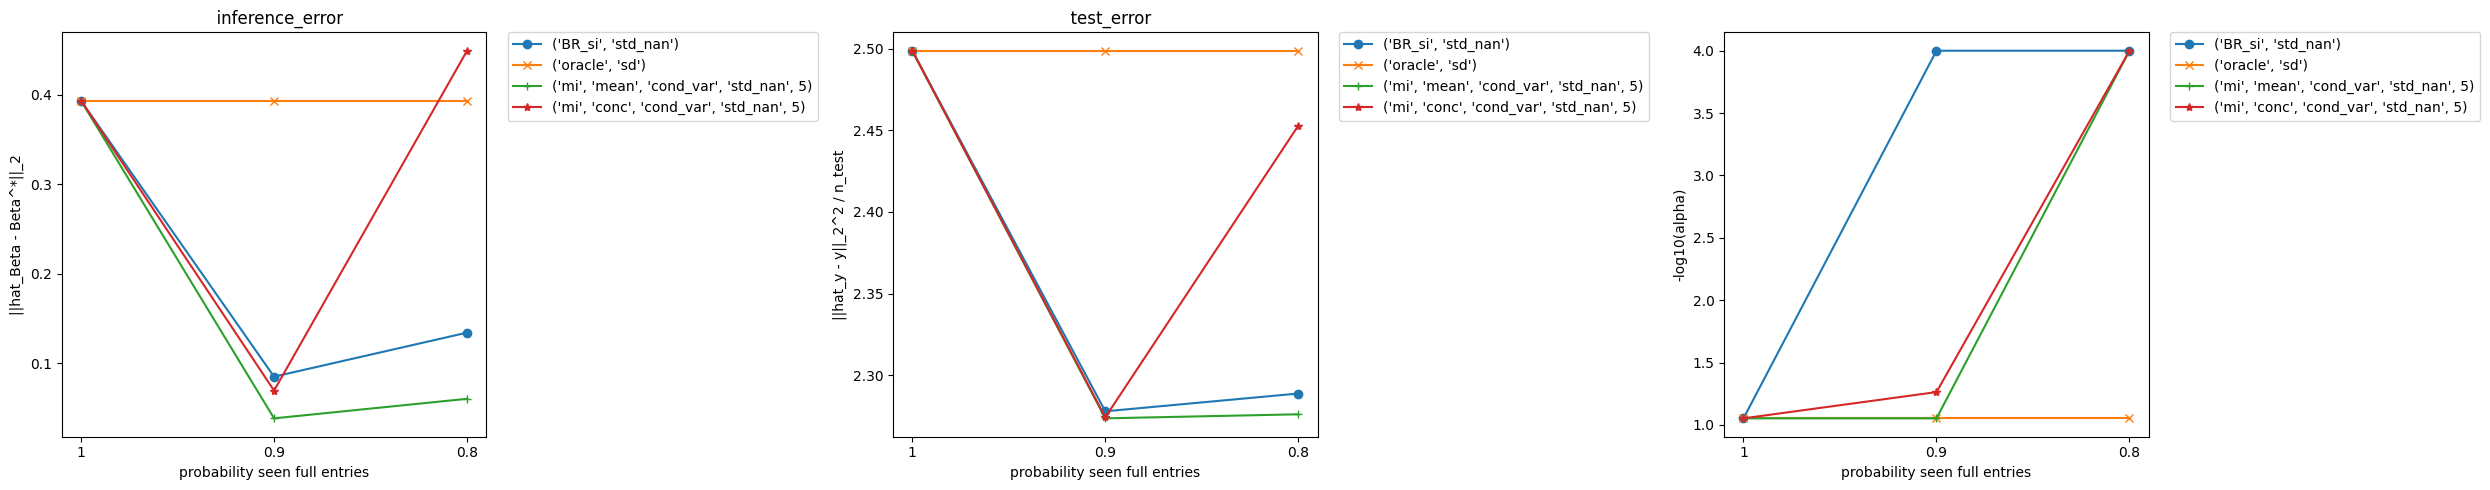

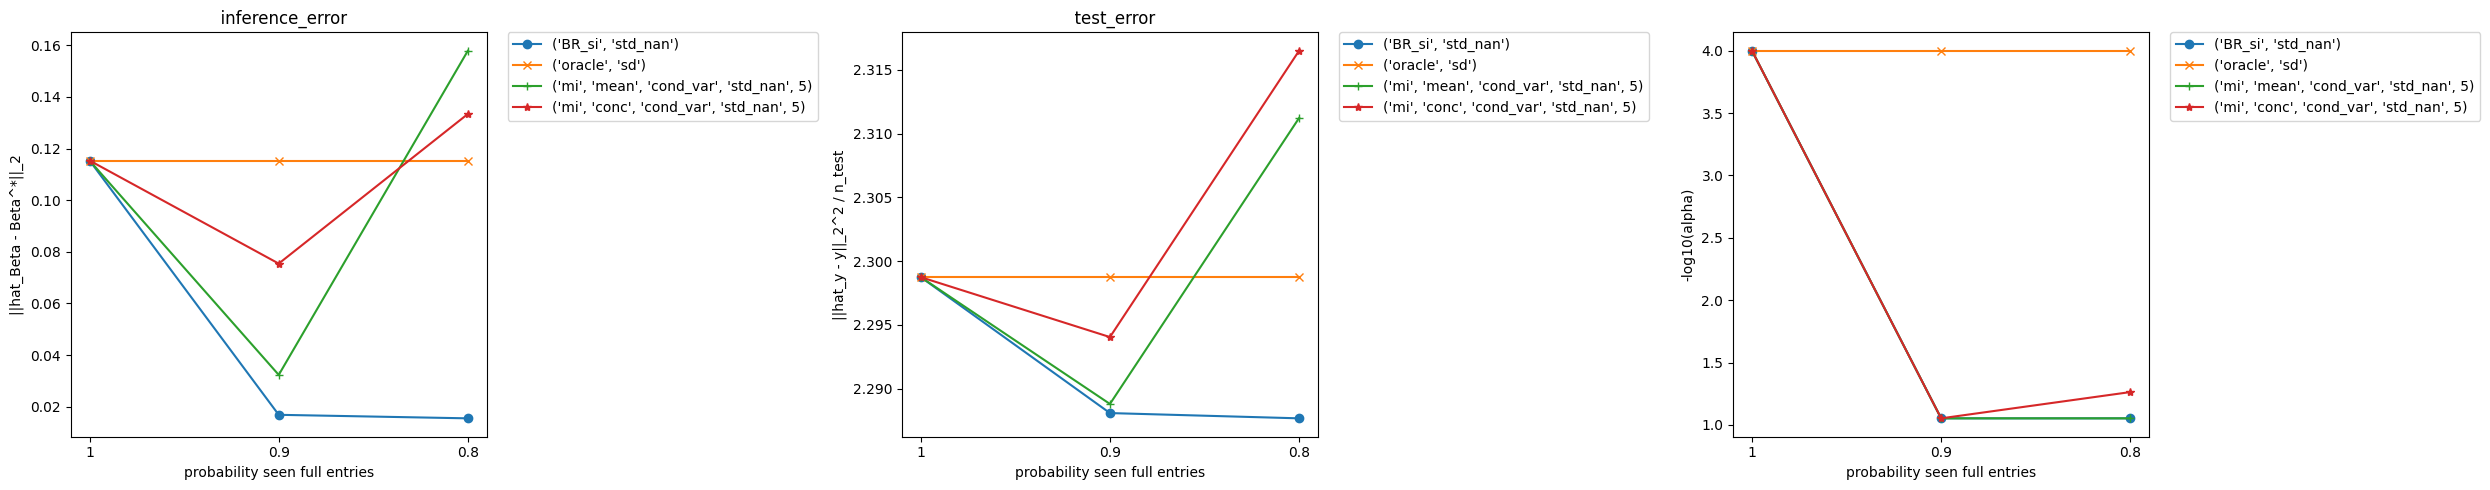

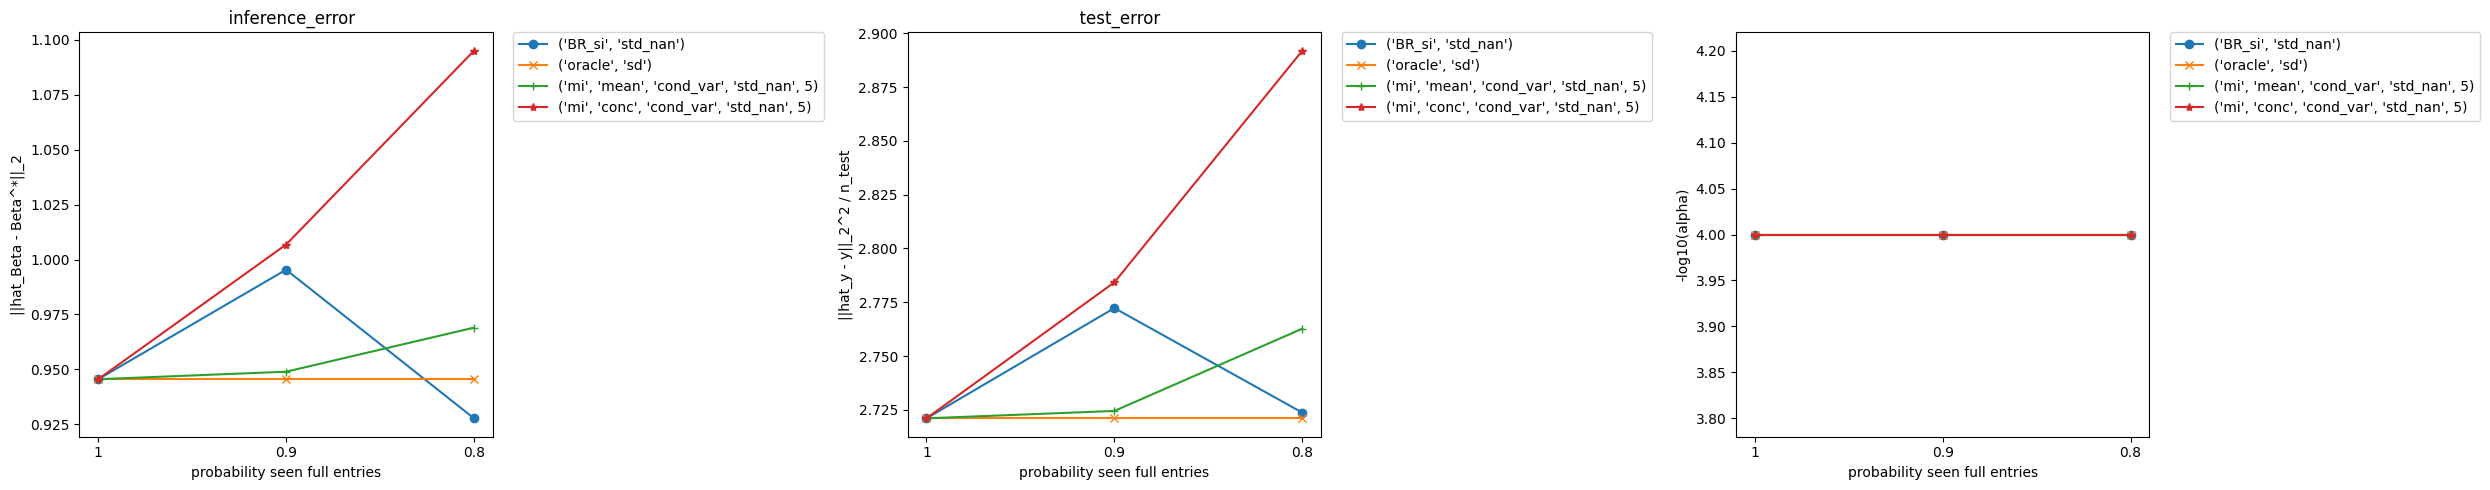

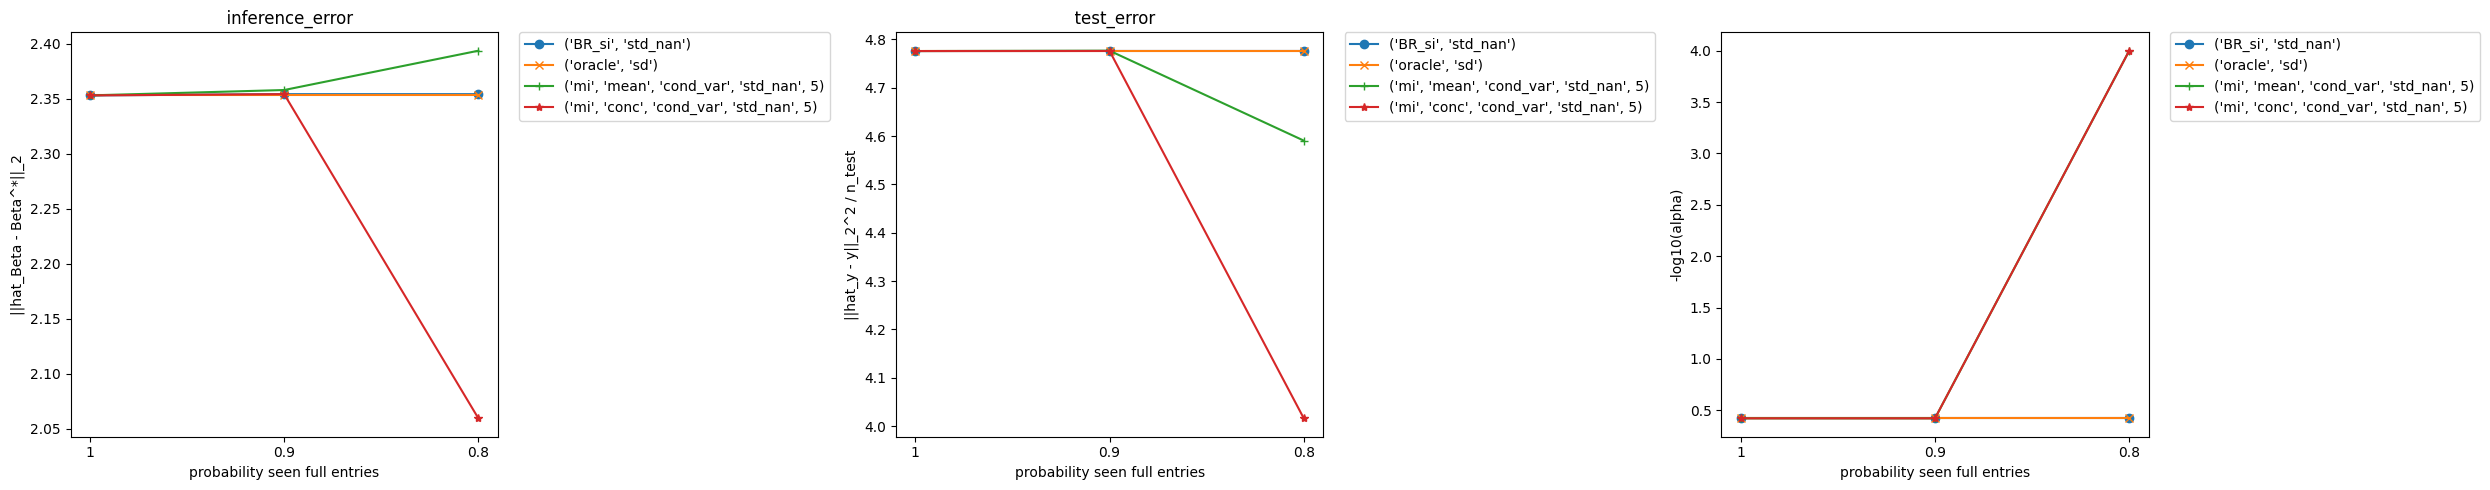

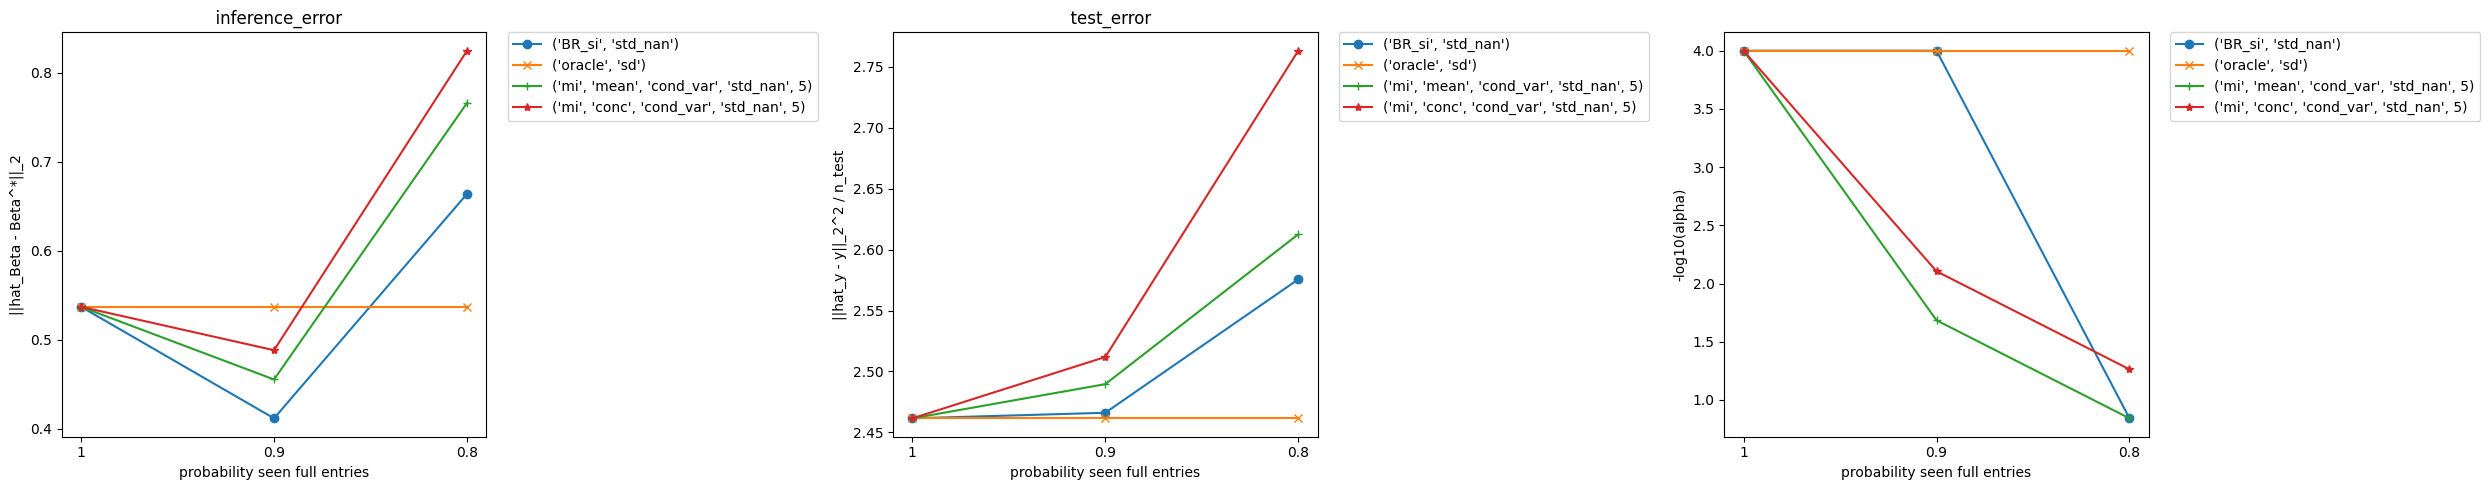

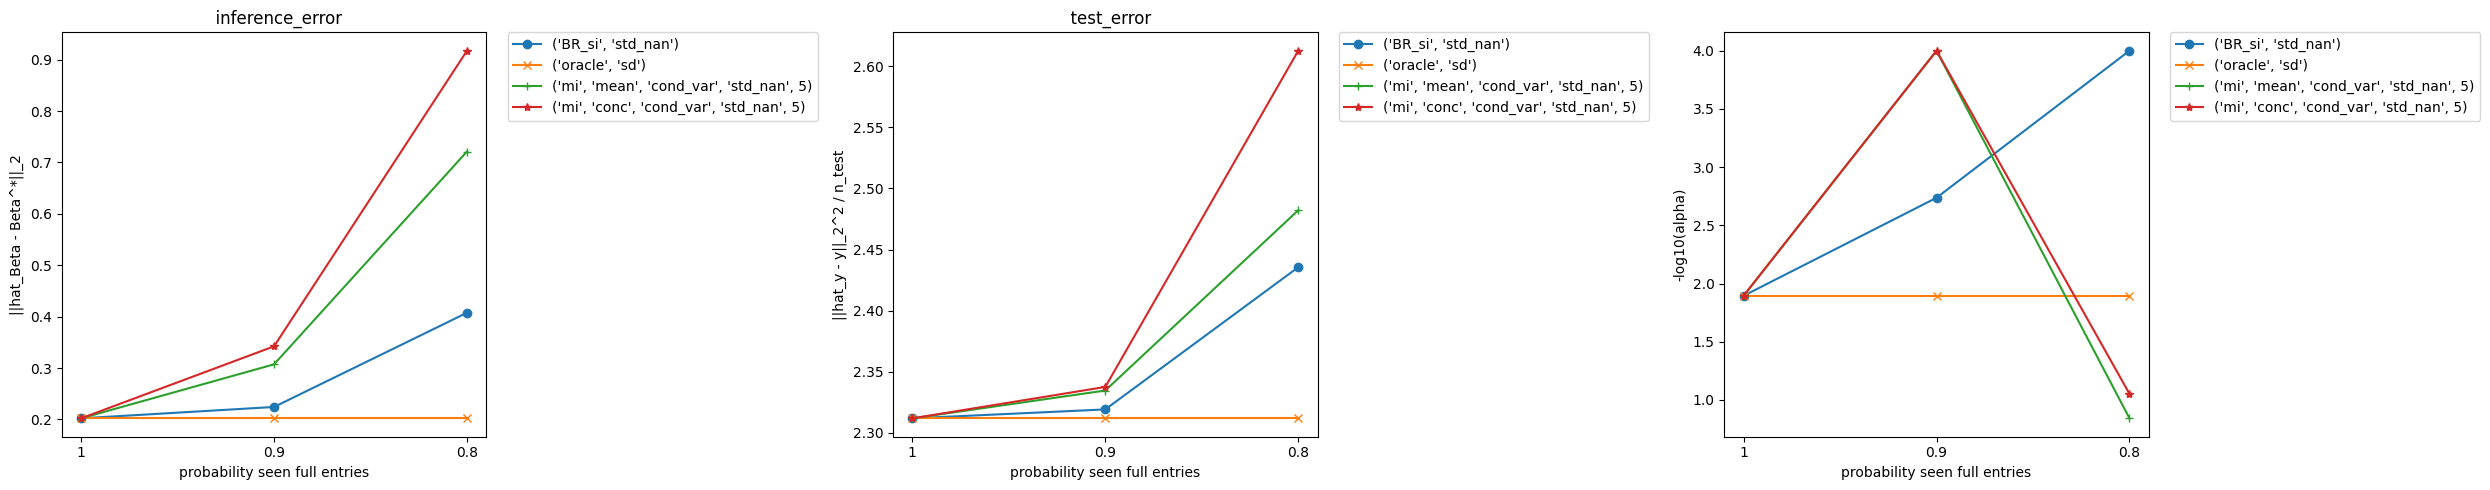

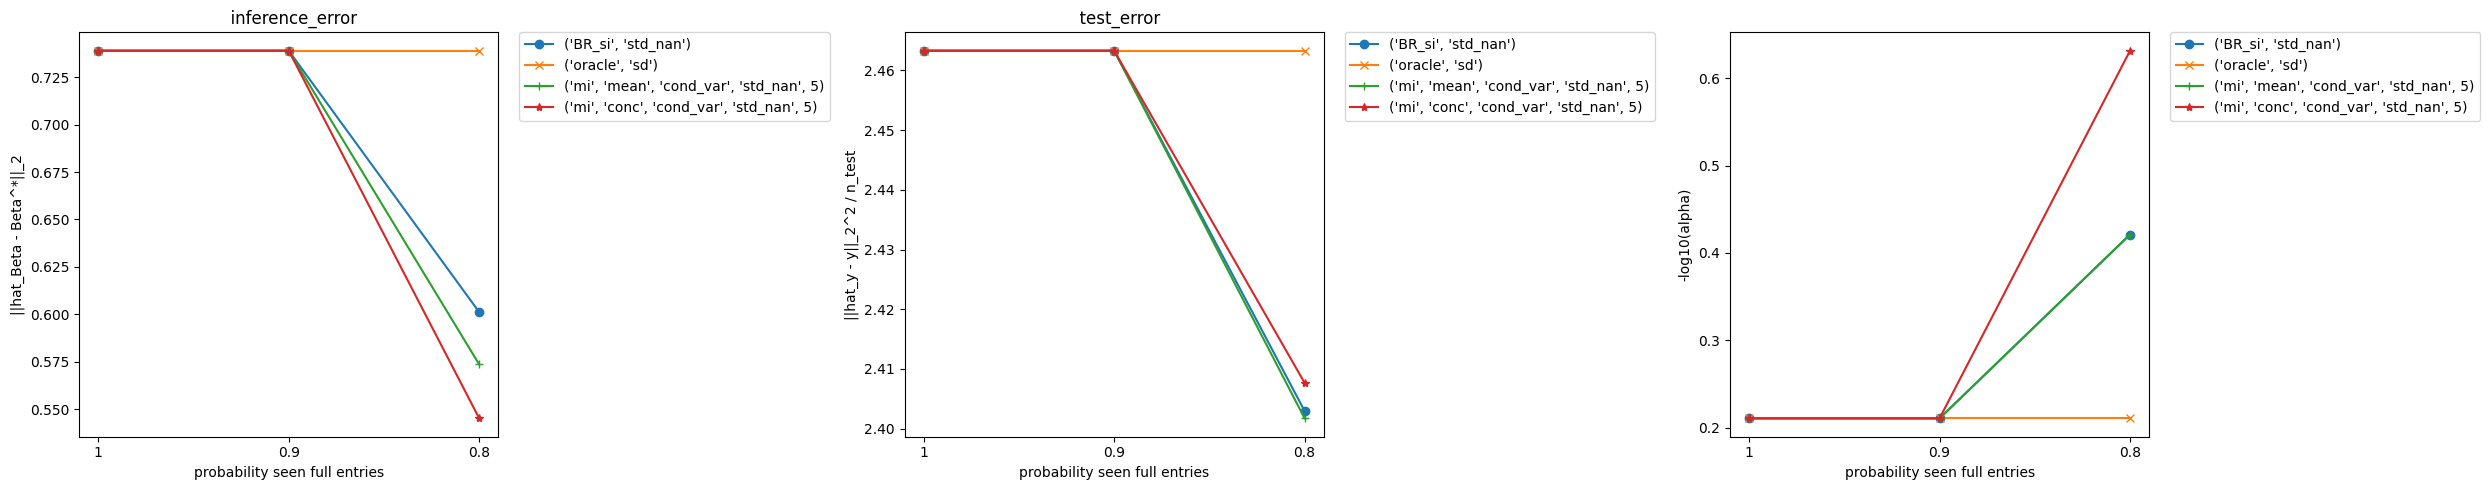

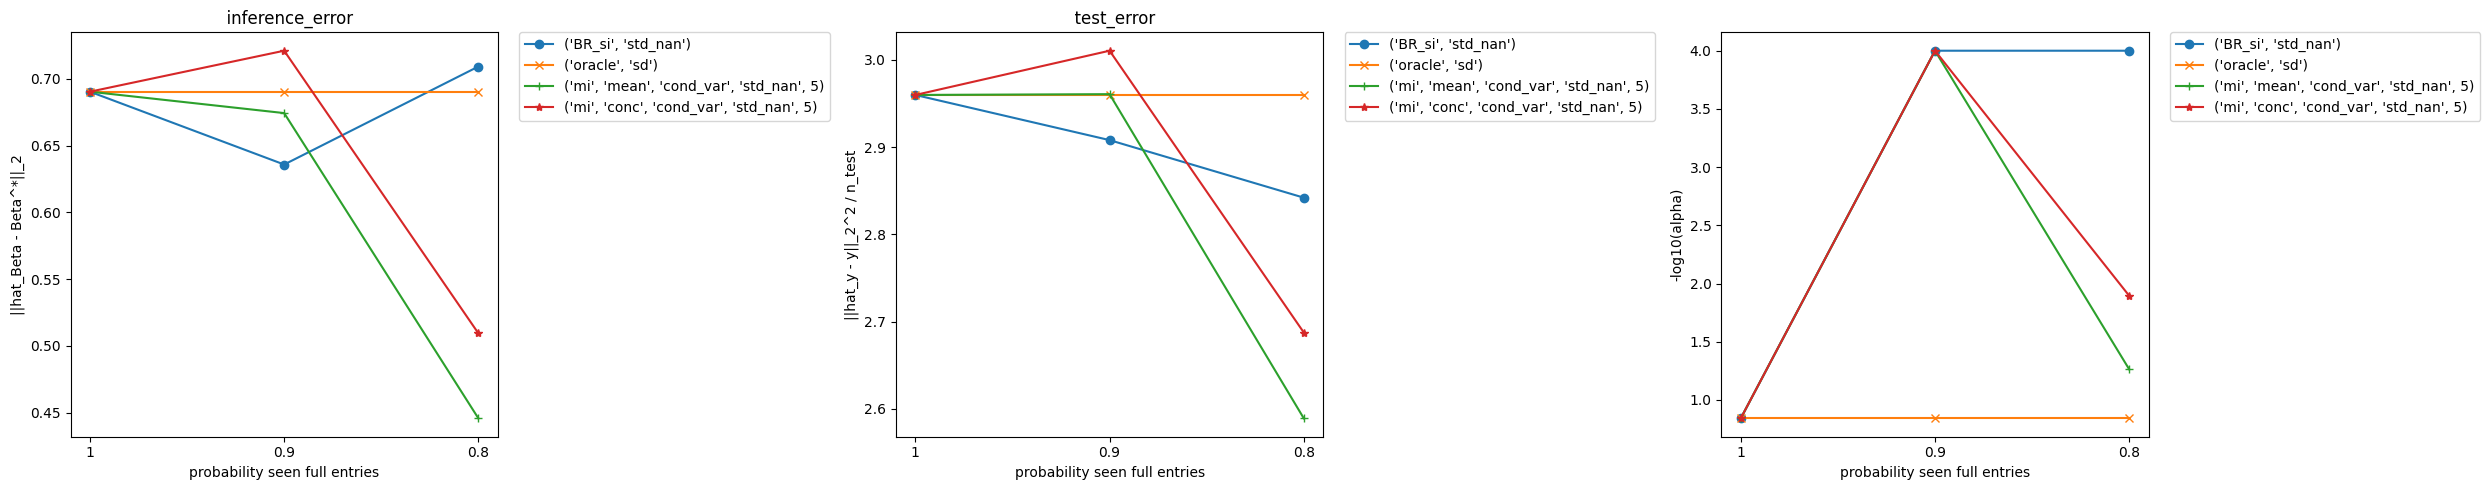

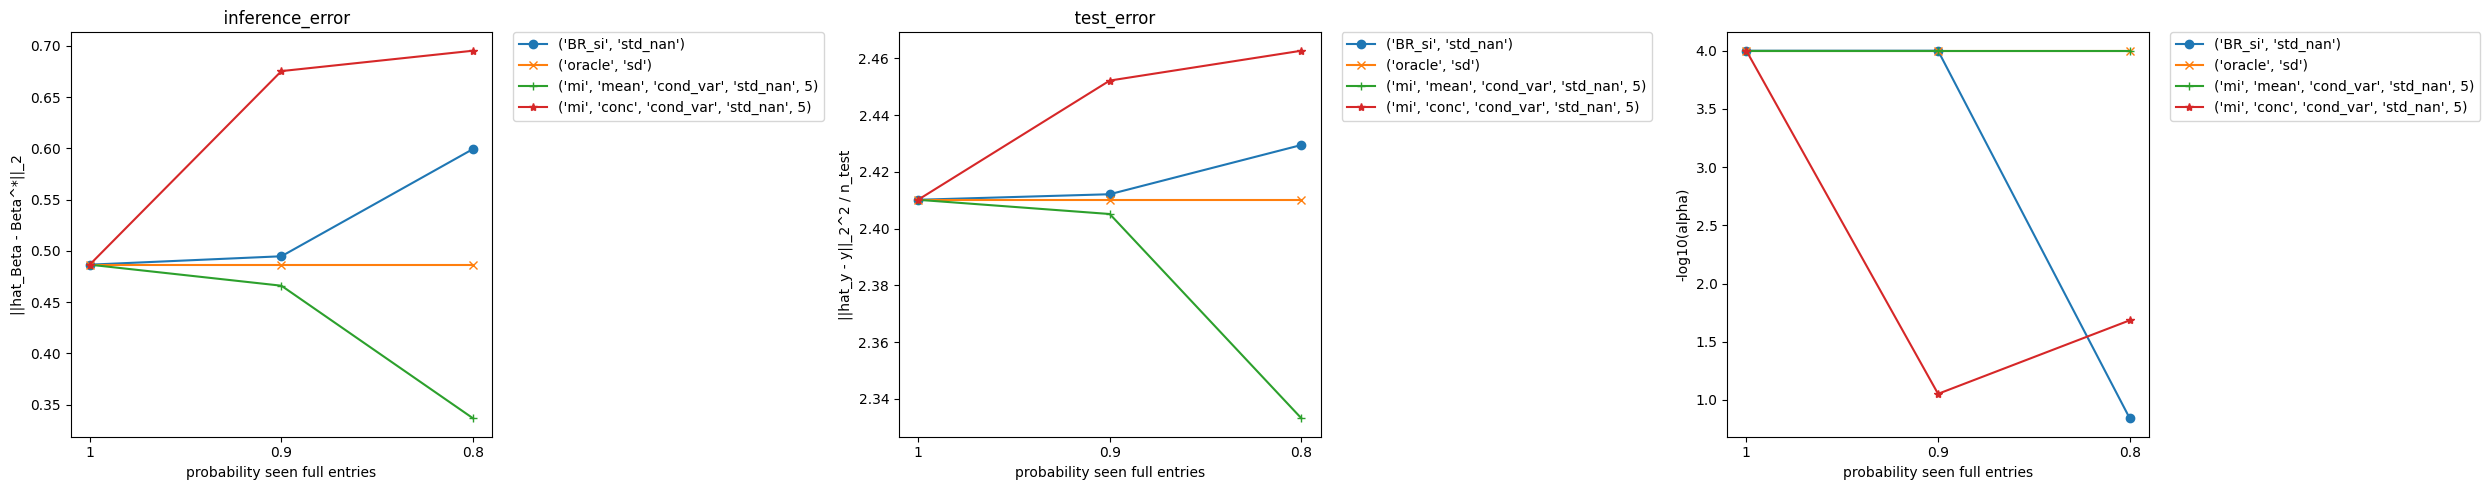

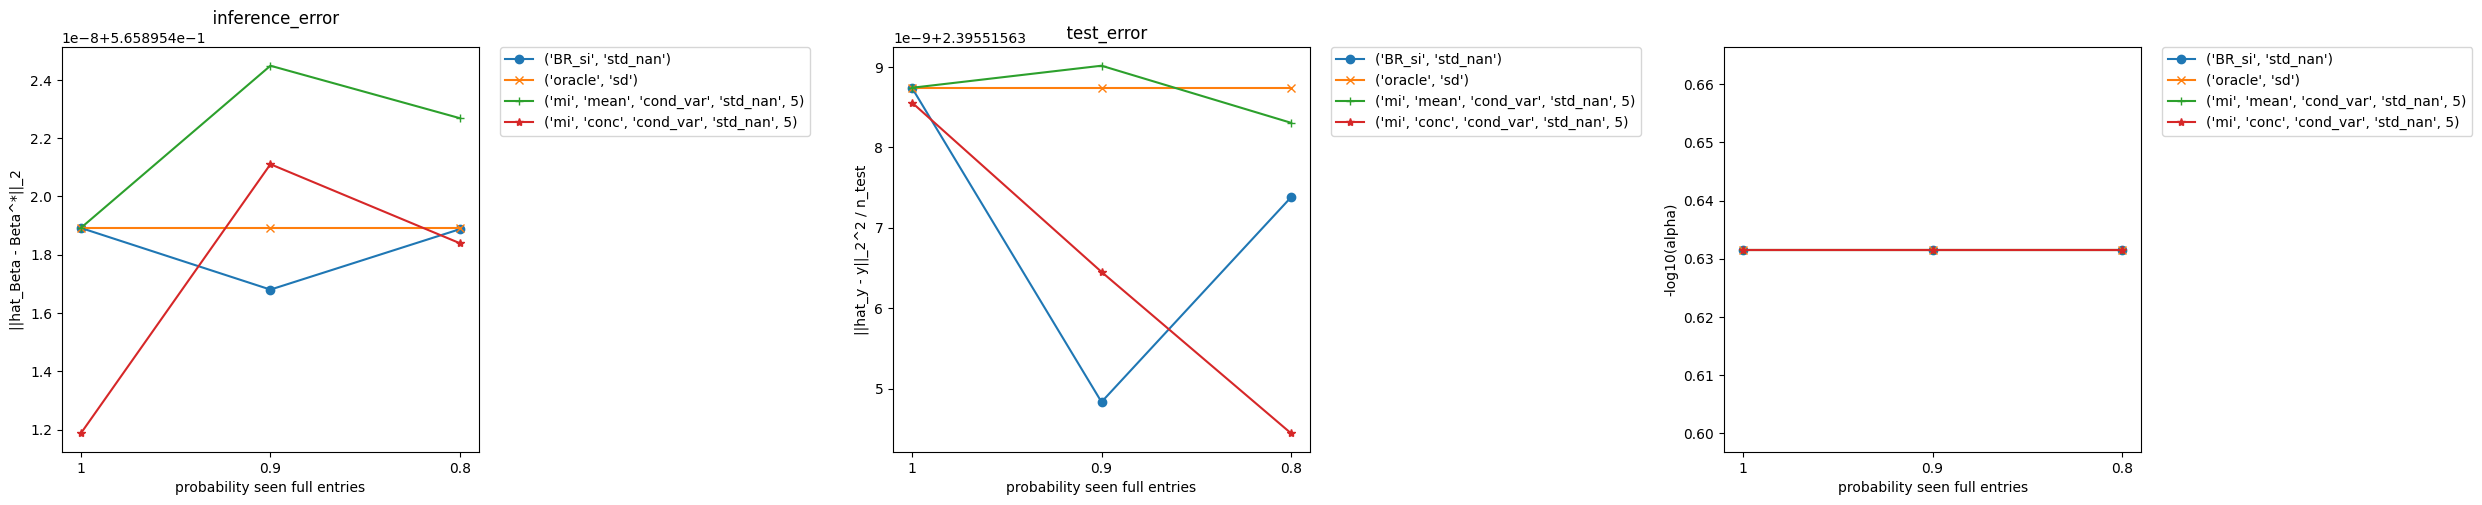

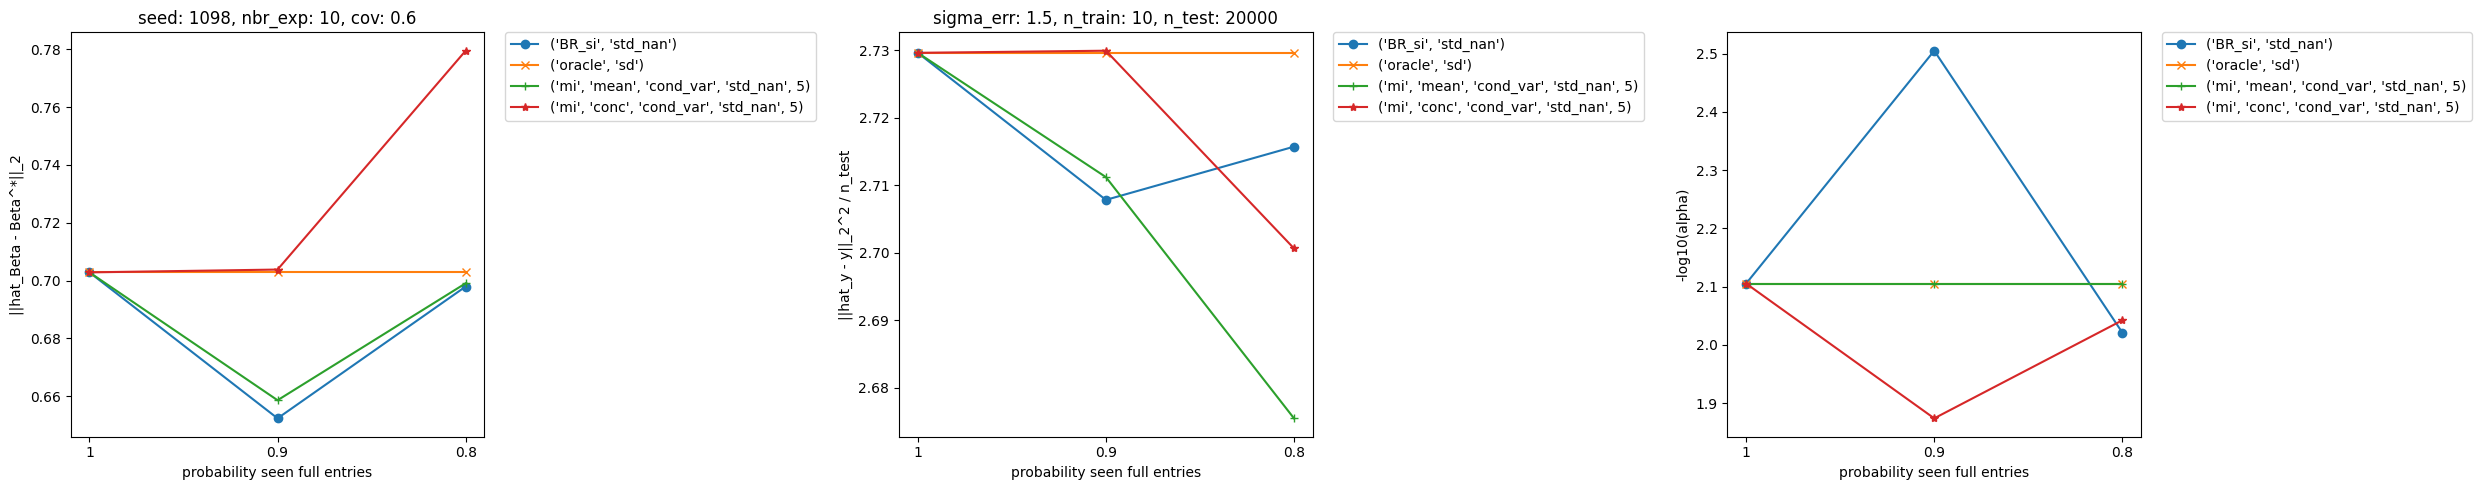

In [10]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [10] * length_vec
error_vec =  [1.5] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, cov_var], [cov_var, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation': gen, 'title_infer_error':'  inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 0, 'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'n_a_dts': 20, 'n_a_mis':1}}

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        {'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 10
seed = 1098
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [22]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)



[[[0 0 0 0]
  [0 1 0 0]
  [0 0 1 0]
  [0 1 0 1]]

 [[1 0 0 0]
  [0 1 0 0]
  [0 0 1 0]
  [1 0 0 0]]

 [[0 0 0 0]
  [0 0 1 1]
  [0 0 0 0]
  [0 0 0 1]]]
[[[0 0 0 0]
  [0 1 0 0]
  [0 0 1 0]
  [0 1 0 1]]

 [[1 0 0 0]
  [0 2 0 0]
  [0 0 2 0]
  [1 1 0 1]]

 [[1 0 0 0]
  [0 2 1 1]
  [0 0 2 0]
  [1 1 0 2]]]
[[[0 0 0 0]
  [0 1 0 0]
  [0 0 1 0]
  [0 1 0 1]]

 [[1 0 0 0]
  [0 1 0 0]
  [0 0 1 0]
  [1 1 0 1]]

 [[1 0 0 0]
  [0 1 1 1]
  [0 0 1 0]
  [1 1 0 1]]]
